# A study of traffic crashes in the city of Tempe, Arizona USA
***

## Motivation
<span style="color:red">

- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?
</span>


## Basic stats
<span style="color:red">
Let's understand the dataset better

- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.
</span>

In [38]:
import numpy as np
import urllib.request
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import colors as mcolors
from sklearn.metrics import r2_score
import calplot
import seaborn as sns
from datetime import datetime, timedelta
import math
from math import radians, cos, sin, asin, sqrt

import folium

from urllib.request import urlopen
import json
import plotly.express as px

# Import libraries to make heatmap
from folium import plugins
from folium.plugins import HeatMap


We use data collected by the City of Tempe[[1]](https://catalog.data.gov/dataset/1-08-crash-data-report-detail-498c3?fbclid=IwZXh0bgNhZW0CMTAAAR2gojdIAxiOMs5ieTM0OfPH9MRPHGxzhgibobwIDFZ-Q_a3sfCUwDDjulc_aem_AfOI4PVUgDLCxCQPW-KQRHPDK12C9L5KYSnbZi0UdAEu0idNK3ofrogdHd3BliKSjuNfI4PJcuzTLqxwJT-HwPpS). The data spans from 2012 - 2024. However, in the data description it is stated that the data is incomplete for 2023 (and obviously also for 2024). We therefore exclude the data from 2023 and 2014 for the remainder of the study. Moreover, the time related data has been saved in UTC but is intended to be viewed in Arizona time which is UTC-07:00 (7 hours behind UTC) and does not adjust for daylight savings (as Arizona does not partake in daylight savings). We have corrected the time-data to Arizona time below.

The data has been collected as part of the _Vision Zero_[[2]](https://www.tempe.gov/government/transportation-and-sustainability/transportation/vision-zero) project, which the City of Tempe is partaking in:

_"Vision Zero is a data-driven traffic safety policy that takes an ethical approach towards achieving safety for all road users. The goal is to achieve a reduction in the number of fatal and serious injury crashes to zero in Tempe, because everyone deserves to get home safely."_

Tempe's Vision Zero Action Plan[[3]](https://www.tempe.gov/home/showpublisheddocument/74455) was approved in May 2019 and already in 2020, the city began implimenting its first traffic safety improvements. As these improvements collide with the Covid-19 pandemic, it is difficult to access the effectiveness of the new measures.  

To begin our analysis we will look at some basic stats and distributions for the data:

In [46]:
# Read data 
data = pd.read_csv("1.08_Crash_Data_Report_(detail).csv")

# subtract 7 hours
data['DateTime'] = pd.to_datetime(data['DateTime']) - timedelta(hours=7)

# Filter the DataFrame to exclude entries from the year 2024
df = data[data['DateTime'].dt.year != 2024] 

# Filter the DataFrame to exclude entries from the year 2023 incomplete
df = data[data['DateTime'].dt.year != 2023] 

# add hour as a column
df.loc[:, 'Hour']  =  df['DateTime'].dt.hour

print("The data post processing contains (num crashes, features): ",df.shape)
df.head()

The data post processing contains (num crashes, features):  (46467, 36)


/tmp/ipykernel_99650/1376581005.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Hour']  =  df['DateTime'].dt.hour


,X,Y,OBJECTID,Incidentid,DateTime,Year,StreetName,CrossStreet,Distance,JunctionRelation,...,Age_Drv2,Gender_Drv2,Traveldirection_Two,Unitaction_Two,Violation1_Drv2,AlcoholUse_Drv2,DrugUse_Drv2,Latitude,Longitude,Hour
0,-111.95221,33.42191,1,2598369,2012-01-01 00:25:00+00:00,2012,University Dr,Hardy Dr,0.000,Intersection Non Interchange,...,20.0,Female,East,Going Straight Ahead,No Improper Action,No Apparent Influence,No Apparent Influence,33.42191,-111.95221,0
1,-111.93769,33.42319,2,2593420,2012-01-01 04:45:00+00:00,2012,7th St,Myrtle Ave,139.920,Not Junction Related,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.42319,-111.93769,4
2,-111.89196,33.41842,3,2588493,2012-01-01 11:07:00+00:00,2012,Price Rd,Orange St,0.000,Intersection Interchange,...,31.0,Male,South,Going Straight Ahead,No Improper Action,No Apparent Influence,No Apparent Influence,33.41842,-111.89196,11
3,-111.94791,33.41779,4,2584449,2012-01-01 17:03:00+00:00,2012,11th St,Judd St,200.112,Not Junction Related,...,NaN,NaN,East,Properly Parked,NaN,NaN,NaN,33.41779,-111.94791,17
4,-111.92847,33.34956,5,2592211,2012-01-01 17:12:00+00:00,2012,Rural Rd,Elliot Rd,135.168,Intersection Related Non Interchange,...,20.0,Female,South,Going Straight Ahead,No Improper Action,No Apparent Influence,No Apparent Influence,33.34956,-111.92847,17


After post-processing, we find that the data contains:
46,467 crash incidents each accompanied by 36 features (one of which we added). The full feature list can be viewed below. Each crash incident contains exactly two parties; a driver 1 and a driver 2. A 'driver' can also be a pedestrian or a cyclist.

Note that '_Drv1' and '_One' are features associated with the driver 1 and '_Drv2' and '_Two' are features associated with the driver 2. Moreover, feature 'X' is identical til 'Longitude' and  feature 'Y' is identical til 'Latitude'. 

In [50]:
num_columns = len(df.columns)
columns_per_column = num_columns // 2 

for i in range(columns_per_column):
    print(f"{df.columns[i]:<30} {df.columns[i + columns_per_column]:<30}")

if num_columns % 2 != 0:
    print(df.columns[-1])

X                              Age_Drv1                      
Y                              Gender_Drv1                   
OBJECTID                       Traveldirection_One           
Incidentid                     Unitaction_One                
DateTime                       Violation1_Drv1               
Year                           AlcoholUse_Drv1               
StreetName                     DrugUse_Drv1                  
CrossStreet                    Unittype_Two                  
Distance                       Age_Drv2                      
JunctionRelation               Gender_Drv2                   
Totalinjuries                  Traveldirection_Two           
Totalfatalities                Unitaction_Two                
Injuryseverity                 Violation1_Drv2               
Collisionmanner                AlcoholUse_Drv2               
Lightcondition                 DrugUse_Drv2                  
Weather                        Latitude                      
SurfaceC


## Data Analysis
<span style="color:red">

- Describe your data analysis and explain what you've learned about the dataset.
- If relevant, talk about your machine-learning.
</span>

Calendar plots:


Taking a closer look into the correlation between serious injury crashes and crashes related to alcohol/drugs.

To account for the significant difference in how many cars are on the road (in general; more cars = more crashes), the number of severe injury crashes is normalized by the total number of crashes for every hour of the day.

We purposely do not normalize the crashes with alcohol/drug involvement, as more cars on the road does not necessarily mean more drunk drivers. We saw earlier that most crashes with alcohol/drugs occur during the night, when there undoubtedly is significantly less traffic than during the day.

In [34]:

# new df for severe accidents and for drugs+alcohol:
df_severe = df.loc[df['Injuryseverity'].isin(['Fatal', 'Suspected Serious Injury', 'Incapacitating Injury'])]
df_alco_drug = df[(df['AlcoholUse_Drv1'] == "Alcohol") | (df['DrugUse_Drv1'] == "Drugs") | (df['AlcoholUse_Drv2'] == "Alcohol") | (df['DrugUse_Drv2'] == "Drugs") ]

# Group the filtered DataFrame by hour in a day and count the number of crahes for each
severe_grouped = df_severe.groupby('Hour').size()
alco_drugs_grouped = df_alco_drug.groupby('Hour').size()
all_grouped = df.groupby('Hour').size() # all accidents: used for normalization

normalized_severe = severe_grouped / all_grouped

In [13]:
# function to get a + b in: y = ax +b
def get_a_b_lin_reg(X, Y, N):
  x_mean = X.mean()
  y_mean = Y.mean()
  sum_xy = (X * Y).sum()
  sum_x_squared = (X ** 2).sum()
  numerator = sum_xy - N * x_mean * y_mean
  denominator = sum_x_squared - N * (x_mean ** 2)

  a = numerator / denominator
  b = y_mean - a*x_mean

  return(a, b)

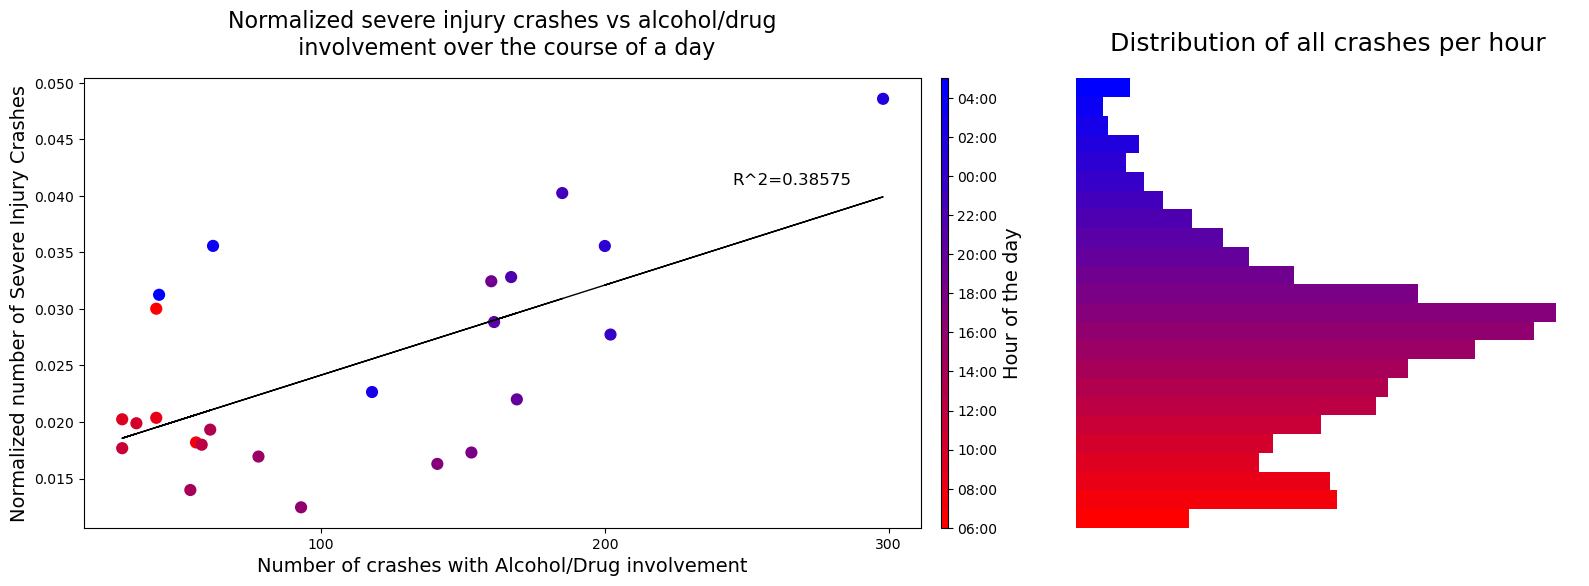

<Figure size 640x480 with 0 Axes>

In [52]:

# Colormap from red to blue
#colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0), (0, 0, 1)]  # Red, yellow, green, blue
colors = [(1, 0, 0), (0, 0, 1)]  # Red to blue
cm = mcolors.LinearSegmentedColormap.from_list('red_blue', colors, N=24)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})  

# Plot scatter__________________________________________________________________________
scatter = axs[0].scatter(alco_drugs_grouped, normalized_severe, c=(normalized_severe.index - 6) % 24, cmap=cm, s=60, vmin=0, vmax=23)  # s= size of points

axs[0].set_title('Normalized severe injury crashes vs alcohol/drug\n involvement over the course of a day', fontsize=16, pad=20, wrap=True)
axs[0].set_xlabel('Number of crashes with Alcohol/Drug involvement', fontsize=14)
axs[0].set_ylabel('Normalized number of Severe Injury Crashes', fontsize=14)
axs[0].set_xticks(np.arange(0, 600, 100))


# plot lin reg: ax+b
a, b = get_a_b_lin_reg(alco_drugs_grouped, normalized_severe, 24)
x_vals = alco_drugs_grouped.values
y_vals = a * x_vals + b
axs[0].plot(x_vals, y_vals, color='black',linewidth=1)

# calc and plot r^2:
r2=np.round(r2_score(normalized_severe, y_vals),5)
axs[0].text(245, 0.041,f'R^2={r2}', fontsize = 12)

# Add colorbar 
sm = ScalarMappable(cmap=cm, norm=scatter.norm)  # Use the same normalization as scatter plot
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[0], label='Hour of the day', aspect=70, pad=0.02)  # shrink if width of bar
cbar.ax.yaxis.label.set_size(14) 

# Colorbar:  Set the tick labels for every other hour
ticks = np.arange(6, 30, 2) % 24  # Adjust the tick positions to start from 6:00 and end at 5:59
tick_labels = [(hour + 6) % 24 for hour in ticks]  # Shift the tick positions to match colormap indices
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{hour:02d}:00' for hour in tick_labels]) #make pretty tick labels

# Bar plot__________________________________________________________________________________
hours = all_grouped.index
bar_colors = cm((hours) % 24)

# Move the first 6 data points to the end (to start at 6 am)
all_grouped_mod = pd.concat([all_grouped[6:], all_grouped[:6]])

# Plot the bar chart with corrected hour values rotated 90 degrees counter-clockwise
bar_width = 1  # width bars
axs[1].barh(range(6, 30), all_grouped_mod, height=bar_width, color=bar_colors)  # Use barh (horizontal) instead of bar
axs[1].set_title('Distribution of all crashes per hour', fontsize=18, pad=20)
#axs[1].set_xlabel('Total number of crashes', fontsize=14)
axs[1].set_yticks([])  # Turn off 
axs[1].set_xticks([])  # Turn off 
axs[1].set_frame_on(False) # hide frame bar plot

# Adjust x-axis limits to remove empty space before and after the last bar (to align nicely with exsisting colorbar)
axs[1].set_ylim(5.5, 29.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



Above, we see the correlation between all severe injury crashes (normalized) and the number of crashes with drug and/or alcohol involvement. 

From the morning and throughout the day, a clear positive correlation is seen from the best-fit straight line (linear regression). However, when considering the value of R^2, it is apparent that the fit of the linear regression model is only moderate. This means that the number of crashes involving alcohol or drugs only moderately influences the normalized number of severe injury crashes. As many other hourly-dependent factors such as light conditions, road conditions, traffic density, driver alertness, etc., also influence the normalized number of severe injury crashes, a "moderate fit at best" is the expected outcome of a simple linear regression model.


## Genre
<span style="color:red">

- Which genre of data story did you use?
- Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
- Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?</span>



## Visualizations

<span style="color:red">

- Explain the visualizations you've chosen.
- Why are they right for the story you want to tell?
</span>


## Discussion
<span style="color:red">
Think critically about your creation

- What went well?,
- What is still missing? What could be improved?, Why? </span>



## Contributions
<span style="color:red">
 Who did what?

- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
- It is not OK simply to write "All group members contributed equally". </span>


<table>
    <tr>
        <th>Task:/Name:</th>
        <th>Lau</th>
        <th>Anna</th>
        <th>Siv</th>
    </tr>
    <tr>
        <td colspan=4 style="text-align: center; border: none;">Notebook tasks:</td>
    </tr>
    <tr>
        <td style="border: 1px solid grey;">Motivation</td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
    <tr>
        <td style="border: 1px solid grey;">Basic Stats</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
    </tr>
    <tr>
        <td style="border: 1px solid grey;">Data Analysis (A)</td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
        <tr>
        <td style="border: 1px solid grey;">Data Analysis (B)</td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
        <tr>
        <td style="border: 1px solid grey;"> ...  </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
        <tr>
        <td style="border: 1px solid grey;"> ...  </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
        <tr>
        <td style="border: 1px solid grey;">Data Analysis (C)</td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
        <tr>
        <td style="border: 1px solid grey;">Data Analysis (D)</td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
        <tr>
        <td style="border: 1px solid grey;">Genre</td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
        <td style="border: 1px solid grey;">   </td>
    </tr>
    <tr>
        <td style="border: 1px solid grey;">Visualizations</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
    </tr>
       <tr>
        <td style="border: 1px solid grey;">Discussion</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
    </tr>
    <tr>
        <td style="border: 1px solid grey;">Proof-reading and layout</td>
        <td style="border: 1px solid grey;">&#10003</td>
        <td style="border: 1px solid grey;">&#10003</td>
        <td style="border: 1px solid grey;">&#10003</td>
    </tr>
    <tr>
        <td colspan=4 style="text-align: center; border: none;">Website tasks:</td>
    </tr>
      <tr>
        <td style="border: 1px solid grey;">0 Introduction</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
    </tr>
       <tr>
        <td style="border: 1px solid grey;">1 Where do accidents happen?</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;"> </td>
        <td style="border: 1px solid grey;"> </td>
    </tr>
       <tr>
        <td style="border: 1px solid grey;">2 When do accidents happen?</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;"> &#10003 </td>
        <td style="border: 1px solid grey;"> (&#10003) </td>
    </tr>
       <tr>
        <td style="border: 1px solid grey;">1.1 Alcohol and drugs</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;"> &#10003</td>
    </tr>
       <tr>
        <td style="border: 1px solid grey;">3 What causes accidents?</td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
        <td style="border: 1px solid grey;">  </td>
    </tr>
    <tr>
        <td style="border: 1px solid grey;">Proof-reading and layout</td>
        <td style="border: 1px solid grey;">&#10003</td>
        <td style="border: 1px solid grey;">&#10003</td>
        <td style="border: 1px solid grey;">&#10003</td>
    </tr>
    <tr>
        <td colspan=4 style="text-align: left; border: none;"> &#10003 = Main contributor </td>
    </tr>
    <tr>
        <td colspan=4 style="text-align: left; border: none;"> (&#10003) = Secondary contributor </td>
    </tr>
</table>


## References

<span style="color:red">

- Make sure that you use references when they're needed and follow academic standards.</span>

[1]   City of Tempe. 1.08 Crash Data Report (detail). https://catalog.data.gov/dataset/1-08-crash-data-report-detail-498c3?fbclid=IwZXh0bgNhZW0CMTAAAR2gojdIAxiOMs5ieTM0OfPH9MRPHGxzhgibobwIDFZ-Q_a3sfCUwDDjulc_aem_AfOI4PVUgDLCxCQPW-KQRHPDK12C9L5KYSnbZi0UdAEu0idNK3ofrogdHd3BliKSjuNfI4PJcuzTLqxwJT-HwPpS. Last accessed on 02-04-2024.

[2]   City of Tempe. Vision Zero. https://www.tempe.gov/government/transportation-and-sustainability/transportation/vision-zero. Last accessed on 24-04-2024.

[3]   City of Tempe. Vision Zero Action Plan. https://www.tempe.gov/home/showpublisheddocument/74455. Last accessed on 24-04-2024.

[4]   [Author/Owner/Organization]. [Page title]. [url].  Last accessed on DD-MM-YYYY.

[5]   [Author/Owner/Organization]. [Page title]. [url].  Last accessed on DD-MM-YYYY.

[6]   [Author/Owner/Organization]. [Page title]. [url].  Last accessed on DD-MM-YYYY.

[7]   [Author/Owner/Organization]. [Page title]. [url].  Last accessed on DD-MM-YYYY.

[8]   [Author/Owner/Organization]. [Page title]. [url].  Last accessed on DD-MM-YYYY.



